In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
warnings.filterwarnings('ignore')

#### Function to read the data

In [2]:
def read_data():
    raw_data = pd.read_csv("DS_exercise_price_response.csv", sep=";").drop(columns=["Unnamed: 0"])
    return raw_data

#### String to float conversion function

In [3]:
def str_to_float(value):
    # Replace ',' with '.' and convert to float
    return float(value.replace(',', '.'))

#### This function calculate summary statistics for a given segment

In [4]:
def analysis(group):
    """
    Args:
        group (DataFrame GroupBy object): GroupBy object representing a segment.

    Returns:
        DataFrame: Summary statistics for the segment.
    """
    data = pd.DataFrame([{
                        "min_price": round(group.X_price.min(), 4), 
                        "max_price": round(group.X_price.max(), 4),
                        "quantile_10": round(group.X_price.quantile(q=0.1), 3),
                        "quantile_90": round(group.X_price.quantile(q=0.9), 3), 
                        "sum_delta_price": round(group.X_price.sum(), 3), 
                        # Pandas series of all X_price sorted given an natural segment by weekday and channel
                        "delta_price": group.X_price.sort_values(), 
                        "mean_price": round(group.X_price.mean(), 4),
                        "cluster size": group.shape[0],
                        "sum_profit": group.profit.sum(),
                        "traffic": group.traffic.sum()}])
    return data

#### Perform K-means clustering on the raw data.

In [5]:
def clustering(raw_data):
    """
    Args:
        raw_data (DataFrame): Input DataFrame containing the raw data.

    Returns:
        DataFrame: DataFrame with an additional 'cluster' column indicating the assigned cluster for each data point.
    """
    features = ['weekday', 'X_price', 'pricing_channel', 'traffic', 'orders']
    X = raw_data[features]
    X_encoded = pd.get_dummies(X, columns=['weekday', 'pricing_channel'])
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(X_encoded)
    raw_data['cluster'] = kmeans.labels_
    return raw_data

####    Plot the 'traffic' and 'X_price' columns from the DataFrame.

In [6]:
def plotter(df):
    fig, ax = plt.subplots()  
    ax2 = ax.twinx()   
    
    df.plot(x='date', y='traffic', kind='line', color='b', figsize=(8, 5),  
            label='Traffic', ax=ax)
    df.plot(x='date', y='X_price', kind='line', color='orange',  
            label='X_price', ax=ax2)  
            
    ax.set_xlabel('Date')
    ax.set_ylabel('Traffic')
    ax2.set_ylabel('X_price')

In [7]:
raw_data = read_data()

#### Convert to float all the elements of X_price, profit_per_order and profit column

In [8]:
raw_data["X_price"] = raw_data.X_price.apply(str_to_float)
raw_data["profit_per_order"] = raw_data.profit_per_order.apply(str_to_float)
raw_data["profit"] = raw_data.profit.apply(str_to_float)

In [9]:
# Dictionary to convert the column 'pricing_channel' to numeric
dictionary_to_number = {"A": 1, "B": 2}

# Map the values in the 'pricing_channel' column using the dictionary
raw_data['pricing_channel'] = raw_data['pricing_channel'].map(dictionary_to_number)

# Drop the 'profit_per_order' column from the DataFrame
raw_data.drop(columns=["profit_per_order"], inplace=True)

In [10]:
raw_data

,date,weekday,X_price,pricing_channel,traffic,profit,orders
0,2022-01-01,6,-0.200,1,1630,1490.00,54
1,2022-01-01,6,-0.100,2,3093,2860.00,92
2,2022-01-02,7,-0.175,1,2312,786.25,51
3,2022-01-02,7,-0.200,2,909,490.00,21
4,2022-01-03,1,0.000,1,2968,3300.00,78
...,...,...,...,...,...,...,...
995,2023-05-13,6,-0.200,2,3111,2400.00,96
996,2023-05-14,7,0.075,1,1468,838.75,19
997,2023-05-14,7,-0.075,2,2011,985.00,37
998,2023-05-15,1,-0.050,1,2421,2402.50,68


#### Group the data by 'weekday' and 'pricing_channel', which represents the natural segmentation of the data, and apply an
#### analysis function. The characteristics of the customers can only be described by two features: 'weekday' and the pricing
#### channel they belong to.

In [11]:
# Group the data by 'weekday' and 'pricing_channel', representing the natural segmentation of the data
first_analysis = raw_data.groupby(["weekday", "pricing_channel"]).apply(analysis)

# Sort the analysis results by 'sum_profit' in descending order
first_analysis = first_analysis.sort_values(["sum_profit"], ascending=False)

# Reset the index and drop the unnecessary 'level_2' column
first_analysis = first_analysis.reset_index().drop(columns=["level_2"])

# Print the first analysis results
first_analysis

,weekday,pricing_channel,min_price,max_price,quantile_10,quantile_90,sum_delta_price,delta_price,mean_price,cluster size,sum_profit,traffic
0,5,2,-0.175,0.2,-0.125,0.175,2.450,279 -0.175 895 -0.175 811 -0.150 195 -...,0.0345,71,191605.00,167177
1,1,2,-0.200,0.2,-0.175,0.147,-1.500,607 -0.200 635 -0.200 663 -0.200 957 -...,-0.0208,72,180546.25,170631
2,4,1,-0.200,0.2,-0.150,0.200,0.725,962 -0.200 304 -0.200 458 -0.200 234 -...,0.0102,71,174098.75,166994
3,5,1,-0.200,0.2,-0.200,0.150,-2.100,40 -0.200 712 -0.200 754 -0.200 530 -...,-0.0296,71,173861.25,167640
4,1,1,-0.200,0.2,-0.172,0.175,-0.225,32 -0.200 718 -0.200 704 -0.175 396 -...,-0.0031,72,172366.25,162582
5,4,2,-0.200,0.2,-0.175,0.200,0.975,25 -0.200 543 -0.200 109 -0.200 179 -...,0.0137,71,164617.50,158536
6,6,2,-0.200,0.2,-0.150,0.175,0.625,995 -0.200 701 -0.200 463 -0.200 911 -...,0.0087,72,151168.75,171514
7,6,1,-0.200,0.2,-0.175,0.172,0.075,0 -0.200 196 -0.200 742 -0.200 672 -...,0.0010,72,144687.50,167083
8,3,2,-0.200,0.2,-0.175,0.175,0.300,499 -0.200 611 -0.200 527 -0.200 681 -...,0.0042,71,133122.50,160760
9,3,1,-0.200,0.2,-0.175,0.175,-0.775,582 -0.2 932 -0.2 666 -0.2 848 -0.2 75...,-0.0109,71,129286.25,158166


In [12]:
# Perform clustering on the raw data
raw_data_clusterized = clustering(raw_data)

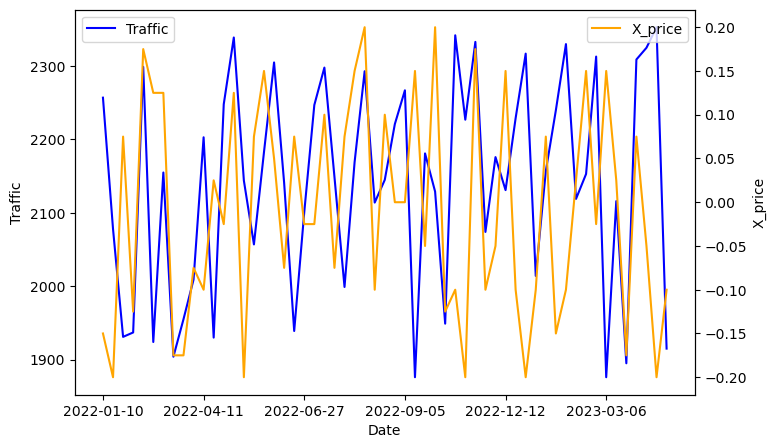

In [13]:
#  Plot the evolution of X_price and traffic for two cluster 
plotter(raw_data_clusterized[(raw_data_clusterized.cluster == 2) & (raw_data_clusterized.weekday == 1)])

In [14]:
# Group the data by 'cluster' and apply an analysis function
after_cluster_analysis = raw_data_clusterized.groupby(["cluster"]).apply(analysis)

# Sort the results by 'sum_profit' in descending order
after_cluster_analysis = after_cluster_analysis.sort_values(["sum_profit"], ascending=False)

# Reset the index and drop the unnecessary 'level_1' column
after_cluster_analysis = after_cluster_analysis.reset_index().drop(columns=["level_1"])

In [15]:
after_cluster_analysis

,cluster,min_price,max_price,quantile_10,quantile_90,sum_delta_price,delta_price,mean_price,cluster size,sum_profit,traffic
0,2,-0.2,0.2,-0.175,0.175,0.35,718 -0.2 608 -0.2 497 -0.2 863 -0.2 61...,0.0009,392,722046.25,837224
1,1,-0.2,0.2,-0.175,0.175,-0.70,527 -0.2 630 -0.2 530 -0.2 848 -0.2 38...,-0.0022,322,715187.50,830834
2,0,-0.2,0.2,-0.150,0.175,2.00,995 -0.2 962 -0.2 847 -0.2 681 -0.2 74...,0.0163,123,336278.75,387263
3,3,-0.2,0.2,-0.175,0.175,-1.30,0 -0.2 138 -0.2 607 -0.2 701 -0.2 19...,-0.0080,163,209047.50,254578


<Axes: >

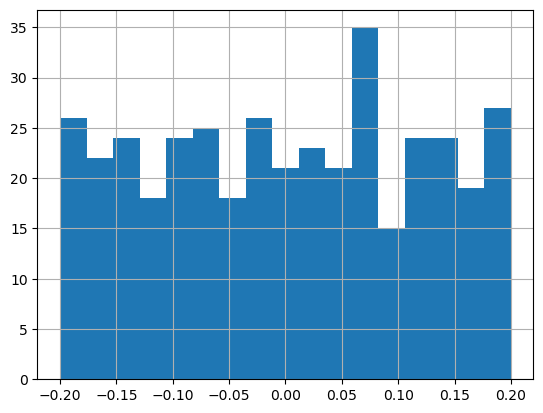

In [16]:
# Distribution of the X_price for a given cluster
after_cluster_analysis.delta_price.loc[0].hist(bins=17)

In [17]:
# Create a new column for the response variable (e.g., orders)
raw_data_clusterized['response'] = raw_data_clusterized['orders']

# Create a column for the price variable (X_price)
raw_data_clusterized['price'] = raw_data_clusterized['X_price']

# Fit a linear regression model
X = raw_data_clusterized[['price']]
y = raw_data_clusterized['response']
model = sm.OLS(y, sm.add_constant(X)).fit()

# Extract the coefficients
intercept = model.params[0]
slope = model.params[1]

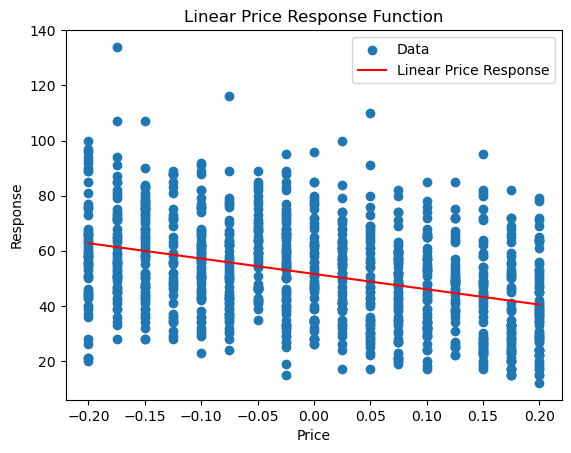

In [18]:
x = np.linspace(raw_data_clusterized['price'].min(), raw_data_clusterized['price'].max(), 100)
y = intercept + slope * x

# Plot the data points
plt.scatter(raw_data_clusterized['price'], raw_data_clusterized['response'], label='Data')

# Plot the linear price response function
plt.plot(x, y, color='red', label='Linear Price Response')

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Response')
plt.title('Linear Price Response Function')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [19]:
# Split the data based on pricing channel
raw_data_cha1 = raw_data[raw_data['pricing_channel'] == 1]  # Filter the data for pricing_channel == 1
raw_data_cha2 = raw_data[raw_data['pricing_channel'] == 2]  # Filter the data for pricing_channel == 2

In [20]:
raw_data_clusterized

,date,weekday,X_price,pricing_channel,traffic,profit,orders,cluster,response,price
0,2022-01-01,6,-0.200,1,1630,1490.00,54,3,54,-0.200
1,2022-01-01,6,-0.100,2,3093,2860.00,92,0,92,-0.100
2,2022-01-02,7,-0.175,1,2312,786.25,51,2,51,-0.175
3,2022-01-02,7,-0.200,2,909,490.00,21,3,21,-0.200
4,2022-01-03,1,0.000,1,2968,3300.00,78,0,78,0.000
...,...,...,...,...,...,...,...,...,...,...
995,2023-05-13,6,-0.200,2,3111,2400.00,96,0,96,-0.200
996,2023-05-14,7,0.075,1,1468,838.75,19,3,19,0.075
997,2023-05-14,7,-0.075,2,2011,985.00,37,2,37,-0.075
998,2023-05-15,1,-0.050,1,2421,2402.50,68,1,68,-0.050


<Axes: title={'center': 'Current Price for Pricing Channel 2'}, xlabel='date'>

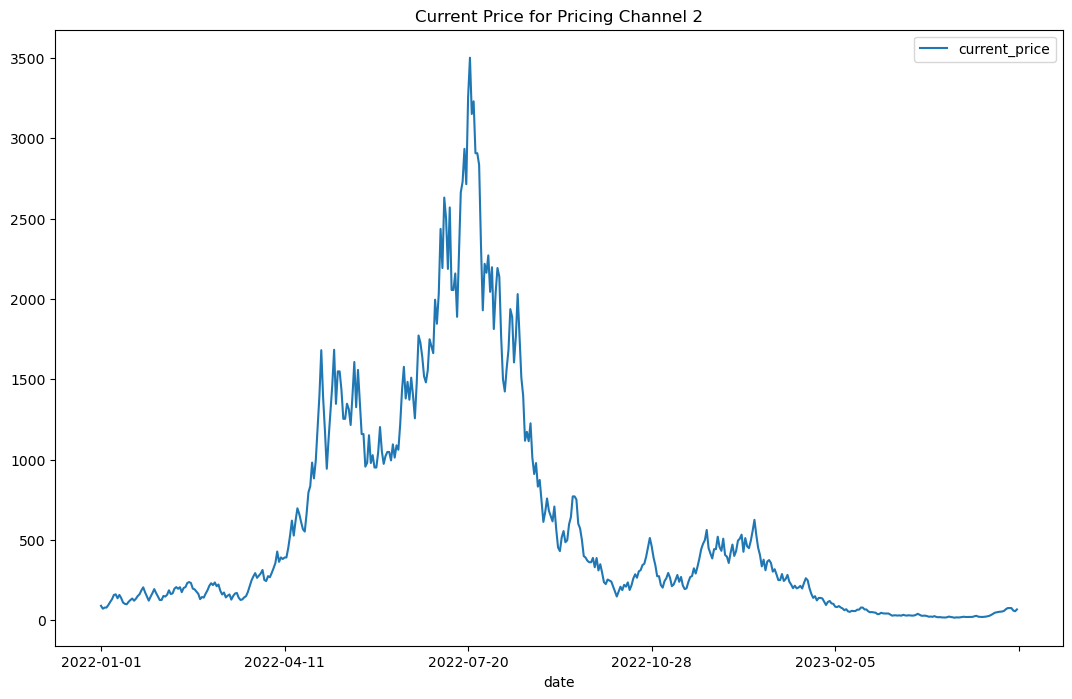

In [21]:
initial_price = 100  # Set the initial price
price_history = []  # Initialize an empty list to store price history

def price_tracker(row):
    """
    Calculate the current price based on the X_price and update the price history.

    Args:
        row (Series): Input row containing 'X_price', 'profit', and other columns.

    Returns:
        Series: The input row with the current price calculated and added.
    """
    global initial_price
    global price_history

    current_price = row['X_price'] * initial_price + initial_price  # Calculate the current price
    price_history.append(current_price)  # Add the current price to the price history list
    initial_price = current_price  # Update the initial price for the next iteration
    return row

raw_data_cha2 = raw_data[raw_data['pricing_channel'] == 2]  # Filter the data for pricing_channel == 2
price_analysis_pdf = raw_data_cha2[['date', 'X_price']].sort_values(by='date')  # Select relevant columns and sort by date
price_analysis_pdf = price_analysis_pdf.apply(price_tracker, axis=1)  # Apply the price_tracker function to each row
price_analysis_pdf['current_price'] = price_history  # Add the price history to the DataFrame as 'current_price' column
price_analysis_pdf.plot(x='date', y='current_price', kind='line', figsize=(13, 8), 
                        title='Current Price for Pricing Channel 2')  # Plot the current price over time
